In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ReceiptDataset(Dataset):
    def __init__(self, image_dir, result_dir, transform=None):
        self.image_dir = image_dir
        self.result_dir = result_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        result_path = os.path.join(self.result_dir, self.image_files[idx])
        
        # Load full image (train_data) and target image (train_results)
        image = Image.open(img_path).convert("RGB")
        result = Image.open(result_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            result = self.transform(result)
        
        return image, result

In [4]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Load the dataset
train_dataset = ReceiptDataset("data/train_data/", "data/train_results/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)
        
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1)  # Final layer to match the RGB channels
        )
        
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return dec1


In [6]:
model = UNet().to(device)
criterion = nn.MSELoss()  # Use MSELoss for pixel-wise difference
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [7]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "receipt_transformer.pth")

Epoch [1/100], Loss: 0.6044
Epoch [2/100], Loss: 0.2890
Epoch [3/100], Loss: 0.0975
Epoch [4/100], Loss: 0.0513
Epoch [5/100], Loss: 0.0316
Epoch [6/100], Loss: 0.0229
Epoch [7/100], Loss: 0.0222
Epoch [8/100], Loss: 0.0219
Epoch [9/100], Loss: 0.0217
Epoch [10/100], Loss: 0.0214
Epoch [11/100], Loss: 0.0210
Epoch [12/100], Loss: 0.0208
Epoch [13/100], Loss: 0.0207
Epoch [14/100], Loss: 0.0204
Epoch [15/100], Loss: 0.0201
Epoch [16/100], Loss: 0.0200
Epoch [17/100], Loss: 0.0199
Epoch [18/100], Loss: 0.0196
Epoch [19/100], Loss: 0.0195
Epoch [20/100], Loss: 0.0193
Epoch [21/100], Loss: 0.0194
Epoch [22/100], Loss: 0.0193
Epoch [23/100], Loss: 0.0190
Epoch [24/100], Loss: 0.0189
Epoch [25/100], Loss: 0.0188
Epoch [26/100], Loss: 0.0194
Epoch [27/100], Loss: 0.0192
Epoch [28/100], Loss: 0.0188
Epoch [29/100], Loss: 0.0186
Epoch [30/100], Loss: 0.0185
Epoch [31/100], Loss: 0.0184
Epoch [32/100], Loss: 0.0184
Epoch [33/100], Loss: 0.0185
Epoch [34/100], Loss: 0.0184
Epoch [35/100], Loss: 0

In [8]:
import matplotlib.pyplot as plt
model = UNet().to(device)
model.load_state_dict(torch.load("receipt_transformer.pth", map_location=device))
model.eval() 

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

def predict(image_path):
    # Load and preprocess the input image
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = output.squeeze().cpu()  # Remove batch dimension and move to CPU

    # Convert output to a numpy array and visualize/save
    output = output.permute(1, 2, 0).numpy()  # Convert from CHW to HWC format
    output = np.clip(output, 0, 1)  # Ensure pixel values are in [0, 1]
    
    plt.imshow(output)
    plt.show()

C:\Users\szcze\AppData\Local\Temp\ipykernel_190184\2184087056.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("receipt_transformer.pth",

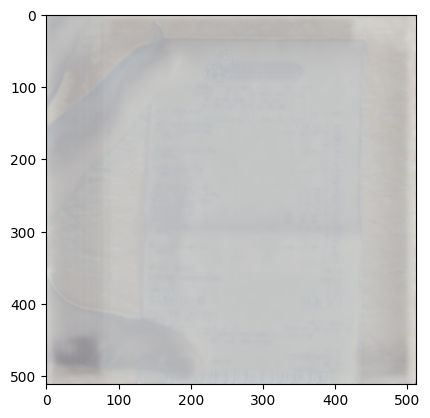

In [12]:
predict("data/valid_data/42.jpg")